In [1]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt

In [2]:
# data source: 
# TODO: function to read csv
# put csv in "__init__ main" to execute
def load_flu_file(file):
    flu_df = pd.read_csv(file, header = 2)
    return flu_df

In [3]:
# data source: https://trends.google.com/trends/explore?date=2019-01-01%202020-10-27&geo=US&q=mask
# TODO: function to analyze mask google trend
# read and clean
def load_mask_file(file):
    new_header = ['Date', 'mask_interested_in_percentage']
    mask_df = pd.read_csv(file, header = 1, names = new_header)
    return mask_df

In [4]:
# data source: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
# TODO: function to analyze covid case
# read and clean

covid = pd.read_excel('COVID-19-worldwide.xlsx')
covid
# covid.groupby(["year", "month"]).sum()["cases"]

# 變成dataframe然後取出個國家的確認數&日期
# 看要不要group by年、月

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,2020-11-23,23,11,2020,252,8,Afghanistan,AF,AFG,38041757.0,Asia,6.655844
1,2020-11-22,22,11,2020,154,12,Afghanistan,AF,AFG,38041757.0,Asia,6.203709
2,2020-11-21,21,11,2020,232,25,Afghanistan,AF,AFG,38041757.0,Asia,6.130106
3,2020-11-20,20,11,2020,282,5,Afghanistan,AF,AFG,38041757.0,Asia,5.672714
4,2020-11-19,19,11,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,5.036571
...,...,...,...,...,...,...,...,...,...,...,...,...
57422,2020-03-25,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
57423,2020-03-24,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
57424,2020-03-23,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
57425,2020-03-22,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN


In [5]:
def get_covid_cases(country_name: str):
    if country_name == "US":
        country_name = "United_States_of_America"
    elif country_name == "UK":
        country_name = "United_Kingdom"
    country = covid.loc[covid["countriesAndTerritories"] == country_name]
    # country_new = country.groupby(["year", "month"]).sum()["cases"]
    # print(df)
    country["yearmonth"] = country["dateRep"].map(lambda dt: dt.replace(day=1))
    country_new = country.groupby(["yearmonth"]).sum()["cases"]
    return country_new

In [6]:
# columns we want: year, month, ALL_INF, mask google trend
# TODO: function to make a separte column of datetime
# and then group by 1. year and 2. month (2 conditions)   ('ALL_INF')



In [7]:
def get_total_flu_case_by_month(file):
    file["yearmonth"] = pd.to_datetime(file["EDATE"]).map(lambda dt: dt.replace(day=1))
    file_new = file.groupby(["yearmonth"]).sum()["ALL_INF"]
    return file_new

In [8]:
def get_mask_search_trend_by_month(file):
    file["yearmonth"] = pd.to_datetime(file["Date"]).map(lambda dt: dt.replace(day=1))
    file_new = file.groupby(["yearmonth"]).sum()["mask_interested_in_percentage"]
    return file_new

In [9]:
# aggregrate everything by country
# columns: year, month, mask, flu, covid
def aggregrate_data(flu_data, mask_data, covid_cases, country_name: str):
    merge = pd.concat([flu_data, mask_data, covid_cases], axis = 1).reset_index()
    merge["Y"] = merge["yearmonth"].dt.year
    merge["M"] = merge["yearmonth"].dt.month
    merge["country"] = country_name
    merge = merge[["Y", "M", "country", "ALL_INF", "mask_interested_in_percentage", "cases"]]
    merge = merge.rename(columns = {"ALL_INF": "flu cases"})
    return merge

In [10]:
def extract_info(country: str):
    flu = "FluNetInteractiveReport_" + country + ".csv"
    mask = "multiTimeline_" + country + ".csv"
    
    fludata = load_flu_file(flu)
    mask_trend = load_mask_file(mask)
    fludata_new = get_total_flu_case_by_month(fludata)
    mask_trend_new = get_mask_search_trend_by_month(mask_trend)
    covid_case = get_covid_cases(country)
    result_data = aggregrate_data(fludata_new, mask_trend_new, covid_case, country)
    return result_data
    

In [11]:
# Data visualization
# import matplotlib as plt
def plot_graph(country: str):
    flucase=country['flu cases']
    DATE = []
    for y, m in zip(country.Y, country.M):
        DATE.append(date(y, m,1))
    country['DATE'] = DATE
    time=country['DATE']
    plt.plot(time,flucase)
    plt.xlabel('month')
    plt.ylabel('num. of cases')
    plt.show()


In [14]:
# if __name__ == "__main__":
# files
"""
flu_china = 'FluNetInteractiveReport_China.csv'
flu_usa = 'FluNetInteractiveReport_US.csv'
flu_uk = 'FluNetInteractiveReport_UK.csv'
mask_china = 'multiTimeline_China.csv'
mask_usa = 'multiTimeline_US.csv'
mask_uk = 'multiTimeline_UK.csv'
"""

china = extract_info("China")
us = extract_info("US")
# uk = extract_info("UK")
# load data
# fludata_china = load_flu_file(flu_china)
# mask_trend_china = load_mask_file(mask_china)
# clean data
# fludata_china_new = get_total_flu_case_by_month(fludata_china)
# mask_trend_china_new = get_mask_search_trend_by_month(mask_trend_china)
# covid_case = get_covid_cases("China")
# merga all data together
# result_data = aggregrate_data(fludata_china_new, mask_trend_china_new, covid_case, "China")
us

<ipython-input-5-827338926f91>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country["yearmonth"] = country["dateRep"].map(lambda dt: dt.replace(day=1))


,Y,M,country,flu cases,mask_interested_in_percentage,cases
0,2015,1,US,37272.0,NaN,NaN
1,2015,2,US,20066.0,NaN,NaN
2,2015,3,US,12169.0,NaN,NaN
3,2015,4,US,5037.0,NaN,NaN
4,2015,5,US,2054.0,NaN,NaN
...,...,...,...,...,...,...
66,2020,7,US,61.0,214.0,1904462.0
67,2020,8,US,62.0,169.0,1502149.0
68,2020,9,US,85.0,108.0,1193898.0
69,2020,10,US,39.0,109.0,1856366.0


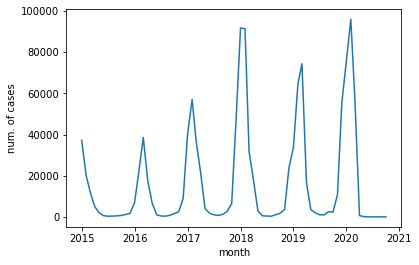

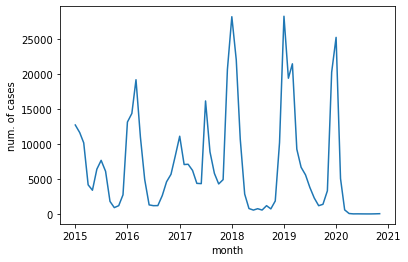

In [16]:
us_graph=plot_graph(us)
# uk_graph=plot_graph(uk)
china_graph=plot_graph(china)


In [ ]:
# load + delete document on github

In [ ]:
# write a function to extract data from specific year

# ex: 2015 = f(data, 2015)
#     2016 = f(data, 2016)

In [ ]:
# plot -> 

In [ ]:
# hypothesis 1 -> 把2019和2020年分開兩張圖，比較flu cases變化 (flu+口罩的線) -> 作結論 (plot x 6)
# hypothesis 2 -> 把covid跟flu的線畫在一張圖中，分三個國家 -> 作結論 (plot x 3) (2019~2020)
# hypothesis 3 -> 2015 ~ 2019 數據疊一起看過去幾年的flu peak，2020數據也疊一起，但是用不同顏色的線表示 -> 作結論 (plot x 1)(2015~2020)

In [ ]:
# china = load_flu_file("FluNetInteractiveReport_China_beforecovid.csv")
# china_flu = get_total_flu_case_by_month(china)
# china_flu

In [ ]:
# hypothesis 1 -> 把2019和2020年分開兩張圖，比較flu cases變化 (flu+口罩的線) -> 作結論 (plot x 6)
# hypothesis 2 -> 把covid跟flu的線畫在一張圖中，分三個國家 -> 作結論 (plot x 3) (2019~2020)
# hypothesis 3 -> 2015 ~ 2019 數據疊一起看過去幾年的flu peak，2020數據也疊一起，但是用不同顏色的線表示 -> 作結論 (plot x 1)(2015~2020)

In [ ]:
# china = load_flu_file("FluNetInteractiveReport_China_beforecovid.csv")
# china_flu = get_total_flu_case_by_month(china)
# china_flu

In [ ]:
# write a function to extract data from specific year

# ex: 2015 = f(data, 2015)
#     2016 = f(data, 2016)

In [ ]:
# plot -> 

In [ ]:
# hypothesis 1 -> 把2019和2020年分開兩張圖，比較flu cases變化 (flu+口罩的線) -> 作結論 (plot x 6)
# hypothesis 2 -> 把covid跟flu的線畫在一張圖中，分三個國家 -> 作結論 (plot x 3) (2019~2020)
# hypothesis 3 -> 2015 ~ 2019 數據疊一起看過去幾年的flu peak，2020數據也疊一起，但是用不同顏色的線表示 -> 作結論 (plot x 1)(2015~2020)

In [ ]:
# china = load_flu_file("FluNetInteractiveReport_China_beforecovid.csv")
# china_flu = get_total_flu_case_by_month(china)
# china_flu

In [ ]:
# hypothesis 1 -> 把2019和2020年分開兩張圖，比較flu cases變化 (flu+口罩的線) -> 作結論 (plot x 6)
# hypothesis 2 -> 把covid跟flu的線畫在一張圖中，分三個國家 -> 作結論 (plot x 3) (2019~2020)
# hypothesis 3 -> 2015 ~ 2019 數據疊一起看過去幾年的flu peak，2020數據也疊一起，但是用不同顏色的線表示 -> 作結論 (plot x 1)(2015~2020)

In [ ]:
# china = load_flu_file("FluNetInteractiveReport_China_beforecovid.csv")
# china_flu = get_total_flu_case_by_month(china)
# china_flu

In [ ]:
# write a function to extract data from specific year

# ex: 2015 = f(data, 2015)
#     2016 = f(data, 2016)

In [ ]:
# plot -> 

In [ ]:
# hypothesis 1 -> 把2019和2020年分開兩張圖，比較flu cases變化 (flu+口罩的線) -> 作結論 (plot x 6)
# hypothesis 2 -> 把covid跟flu的線畫在一張圖中，分三個國家 -> 作結論 (plot x 3) (2019~2020)
# hypothesis 3 -> 2015 ~ 2019 數據疊一起看過去幾年的flu peak，2020數據也疊一起，但是用不同顏色的線表示 -> 作結論 (plot x 1)(2015~2020)

In [ ]:
# china = load_flu_file("FluNetInteractiveReport_China_beforecovid.csv")
# china_flu = get_total_flu_case_by_month(china)
# china_flu

In [ ]:
# hypothesis 1 -> 把2019和2020年分開兩張圖，比較flu cases變化 (flu+口罩的線) -> 作結論 (plot x 6)
# hypothesis 2 -> 把covid跟flu的線畫在一張圖中，分三個國家 -> 作結論 (plot x 3) (2019~2020)
# hypothesis 3 -> 2015 ~ 2019 數據疊一起看過去幾年的flu peak，2020數據也疊一起，但是用不同顏色的線表示 -> 作結論 (plot x 1)(2015~2020)

In [ ]:
# china = load_flu_file("FluNetInteractiveReport_China_beforecovid.csv")
# china_flu = get_total_flu_case_by_month(china)
# china_flu

In [ ]:
# hypothesis 1 -> 把2019和2020年分開兩張圖，比較flu cases變化 (flu+口罩的線) -> 作結論 (plot x 6)
# hypothesis 2 -> 把covid跟flu的線畫在一張圖中，分三個國家 -> 作結論 (plot x 3) (2019~2020)
# hypothesis 3 -> 2015 ~ 2019 數據疊一起看過去幾年的flu peak，2020數據也疊一起，但是用不同顏色的線表示 -> 作結論 (plot x 1)(2015~2020)

In [ ]:
# china = load_flu_file("FluNetInteractiveReport_China_beforecovid.csv")
# china_flu = get_total_flu_case_by_month(china)
# china_flu

In [ ]:
# write a function to extract data from specific year

# ex: 2015 = f(data, 2015)
#     2016 = f(data, 2016)

In [ ]:
# plot -> 

In [ ]:
# hypothesis 1 -> 把2019和2020年分開兩張圖，比較flu cases變化 (flu+口罩的線) -> 作結論 (plot x 6)
# hypothesis 2 -> 把covid跟flu的線畫在一張圖中，分三個國家 -> 作結論 (plot x 3) (2019~2020)
# hypothesis 3 -> 2015 ~ 2019 數據疊一起看過去幾年的flu peak，2020數據也疊一起，但是用不同顏色的線表示 -> 作結論 (plot x 1)(2015~2020)

In [ ]:
# china = load_flu_file("FluNetInteractiveReport_China_beforecovid.csv")
# china_flu = get_total_flu_case_by_month(china)
# china_flu

In [ ]:
# hypothesis 1 -> 把2019和2020年分開兩張圖，比較flu cases變化 (flu+口罩的線) -> 作結論 (plot x 6)
# hypothesis 2 -> 把covid跟flu的線畫在一張圖中，分三個國家 -> 作結論 (plot x 3) (2019~2020)
# hypothesis 3 -> 2015 ~ 2019 數據疊一起看過去幾年的flu peak，2020數據也疊一起，但是用不同顏色的線表示 -> 作結論 (plot x 1)(2015~2020)

In [ ]:
# china = load_flu_file("FluNetInteractiveReport_China_beforecovid.csv")
# china_flu = get_total_flu_case_by_month(china)
# china_flu

In [ ]:
# write a function to extract data from specific year

# ex: 2015 = f(data, 2015)
#     2016 = f(data, 2016)

In [ ]:
# plot -> 

In [ ]:
# hypothesis 1 -> 把2019和2020年分開兩張圖，比較flu cases變化 (flu+口罩的線) -> 作結論 (plot x 6)
# hypothesis 2 -> 把covid跟flu的線畫在一張圖中，分三個國家 -> 作結論 (plot x 3) (2019~2020)
# hypothesis 3 -> 2015 ~ 2019 數據疊一起看過去幾年的flu peak，2020數據也疊一起，但是用不同顏色的線表示 -> 作結論 (plot x 1)(2015~2020)

In [ ]:
# china = load_flu_file("FluNetInteractiveReport_China_beforecovid.csv")
# china_flu = get_total_flu_case_by_month(china)
# china_flu

In [ ]:
# hypothesis 1 -> 把2019和2020年分開兩張圖，比較flu cases變化 (flu+口罩的線) -> 作結論 (plot x 6)
# hypothesis 2 -> 把covid跟flu的線畫在一張圖中，分三個國家 -> 作結論 (plot x 3) (2019~2020)
# hypothesis 3 -> 2015 ~ 2019 數據疊一起看過去幾年的flu peak，2020數據也疊一起，但是用不同顏色的線表示 -> 作結論 (plot x 1)(2015~2020)

In [ ]:
# china = load_flu_file("FluNetInteractiveReport_China_beforecovid.csv")
# china_flu = get_total_flu_case_by_month(china)
# china_flu

In [ ]:
# hypothesis 1 -> 把2019和2020年分開兩張圖，比較flu cases變化 (flu+口罩的線) -> 作結論 (plot x 6)
# hypothesis 2 -> 把covid跟flu的線畫在一張圖中，分三個國家 -> 作結論 (plot x 3) (2019~2020)
# hypothesis 3 -> 2015 ~ 2019 數據疊一起看過去幾年的flu peak，2020數據也疊一起，但是用不同顏色的線表示 -> 作結論 (plot x 1)(2015~2020)

In [ ]:
# china = load_flu_file("FluNetInteractiveReport_China_beforecovid.csv")
# china_flu = get_total_flu_case_by_month(china)
# china_flu

In [ ]:
# write a function to extract data from specific year

# ex: 2015 = f(data, 2015)
#     2016 = f(data, 2016)

In [ ]:
# plot -> 

In [ ]:
# hypothesis 1 -> 把2019和2020年分開兩張圖，比較flu cases變化 (flu+口罩的線) -> 作結論 (plot x 6)
# hypothesis 2 -> 把covid跟flu的線畫在一張圖中，分三個國家 -> 作結論 (plot x 3) (2019~2020)
# hypothesis 3 -> 2015 ~ 2019 數據疊一起看過去幾年的flu peak，2020數據也疊一起，但是用不同顏色的線表示 -> 作結論 (plot x 1)(2015~2020)

In [ ]:
# china = load_flu_file("FluNetInteractiveReport_China_beforecovid.csv")
# china_flu = get_total_flu_case_by_month(china)
# china_flu

In [ ]:
# hypothesis 1 -> 把2019和2020年分開兩張圖，比較flu cases變化 (flu+口罩的線) -> 作結論 (plot x 6)
# hypothesis 2 -> 把covid跟flu的線畫在一張圖中，分三個國家 -> 作結論 (plot x 3) (2019~2020)
# hypothesis 3 -> 2015 ~ 2019 數據疊一起看過去幾年的flu peak，2020數據也疊一起，但是用不同顏色的線表示 -> 作結論 (plot x 1)(2015~2020)

In [ ]:
# china = load_flu_file("FluNetInteractiveReport_China_beforecovid.csv")
# china_flu = get_total_flu_case_by_month(china)
# china_flu

In [ ]:
# write a function to extract data from specific year

# ex: 2015 = f(data, 2015)
#     2016 = f(data, 2016)

In [ ]:
# plot -> 

In [ ]:
# hypothesis 1 -> 把2019和2020年分開兩張圖，比較flu cases變化 (flu+口罩的線) -> 作結論 (plot x 6)
# hypothesis 2 -> 把covid跟flu的線畫在一張圖中，分三個國家 -> 作結論 (plot x 3) (2019~2020)
# hypothesis 3 -> 2015 ~ 2019 數據疊一起看過去幾年的flu peak，2020數據也疊一起，但是用不同顏色的線表示 -> 作結論 (plot x 1)(2015~2020)

In [ ]:
# china = load_flu_file("FluNetInteractiveReport_China_beforecovid.csv")
# china_flu = get_total_flu_case_by_month(china)
# china_flu

In [ ]:
# hypothesis 1 -> 把2019和2020年分開兩張圖，比較flu cases變化 (flu+口罩的線) -> 作結論 (plot x 6)
# hypothesis 2 -> 把covid跟flu的線畫在一張圖中，分三個國家 -> 作結論 (plot x 3) (2019~2020)
# hypothesis 3 -> 2015 ~ 2019 數據疊一起看過去幾年的flu peak，2020數據也疊一起，但是用不同顏色的線表示 -> 作結論 (plot x 1)(2015~2020)

In [ ]:
# china = load_flu_file("FluNetInteractiveReport_China_beforecovid.csv")
# china_flu = get_total_flu_case_by_month(china)
# china_flu